In [20]:
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
%matplotlib inline

def input_missing_values(x_array):
    _x_array = deepcopy(x_array)
    size = len(_x_array)
    for i, x in enumerate(_x_array):
        for j, f_value in enumerate(x):
            if np.isnan(f_value):
                i_before = i
                i_after = i
                while np.isnan(_x_array[i_before, j]):
                    i_before -= 1
                    if i_before == -1:
                        break
                while np.isnan(_x_array[i_after, j]):
                    i_after += 1
                    if i_after == size:
                        break
                if i_before == -1 and i_after != size:
                    _x_array[i,j] = _x_array[i_after,j]
                elif i_before != -1 and i_after == size:
                    _x_array[i,j] = _x_array[i_before,j]
                elif i_before != -1:
                    _x_array[i,j] = (_x_array[i_before,j] + _x_array[i_after,j])/2
                else:
                    print("Nao ha valores para inputar na coluna de numero %d"%j)
                    return None
    return _x_array

def preprocess_data(data, columns="all", train_size=0.8):
    if columns != "all":
        data = data[columns+["total_cases"]]
    x = data.values[:,:-1]
    x = input_missing_values(x)
    y = data.values[:,-1]
    scaler = StandardScaler()
    x_std = scaler.fit_transform(x)
    train_size = int(train_size * len(x_std))
    x_train = x_std[:train_size,:]
    x_test = x_std[train_size:,:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    return x_train, x_test, y_train, y_test, scaler

def make_regression(regressor, x_train, x_test, y_train, y_test, name=""):
#     regressor.fit(x_train, y_train)

    y_pred = regressor.predict(x_train)

    plt.figure(figsize=(15,7))
    plt.plot([i for i in range(0,len(y_pred))], y_pred, color="blue", label="Predicao")
    plt.plot([i for i in range(0,len(y_pred))], y_train, color="orange", label="Real")
    plt.legend()
    plt.title(name+" - Treino")
    plt.show()
    print("Mean absolute error: %f"%mean_absolute_error(y_train, y_pred))

    y_pred = regressor.predict(x_test)

    plt.figure(figsize=(15,7))
    plt.plot([i for i in range(0,len(y_pred))], y_pred, color="blue", label="Predicao")
    plt.plot([i for i in range(0,len(y_pred))], y_test, color="orange", label="Real")
    plt.legend()
    plt.title(name+" - Teste")
    plt.show()
    print("Mean absolute error: %f"%mean_absolute_error(y_test, y_pred))

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

def find_best_params(model, param_grid, x, y):
    gscv = GridSearchCV(estimator=model, param_grid=param_grid,
                        scoring="neg_mean_absolute_error",
                        cv=10, n_jobs=-1)
    gscv.fit(x, y)
    return gscv.best_estimator_, gscv.cv_results_

In [22]:
x = pd.read_csv("data/dengue_features_train.csv")
y = pd.read_csv("data/dengue_labels_train.csv")
data = x.merge(y, on=("city", "year", "weekofyear")).sort_values(by=["year", "weekofyear"])
data_sj = data[data.city=="sj"]
data_sj = data_sj.drop(labels=["week_start_date","city"], axis=1)
data_iq = data[data.city=="iq"]
data_iq = data_iq.drop(labels=["week_start_date","city"], axis=1)

x_sj, _, y_sj, _, _ = preprocess_data(data_sj, columns="all", train_size=1)
x_train_sj, x_test_sj, y_train_sj, y_test_sj, _ = preprocess_data(data_sj, columns="all", train_size=0.8)

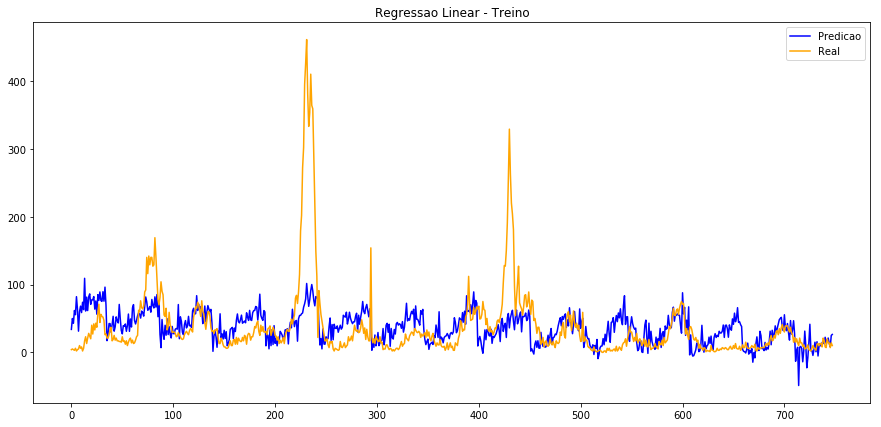

Mean absolute error: 28.006939


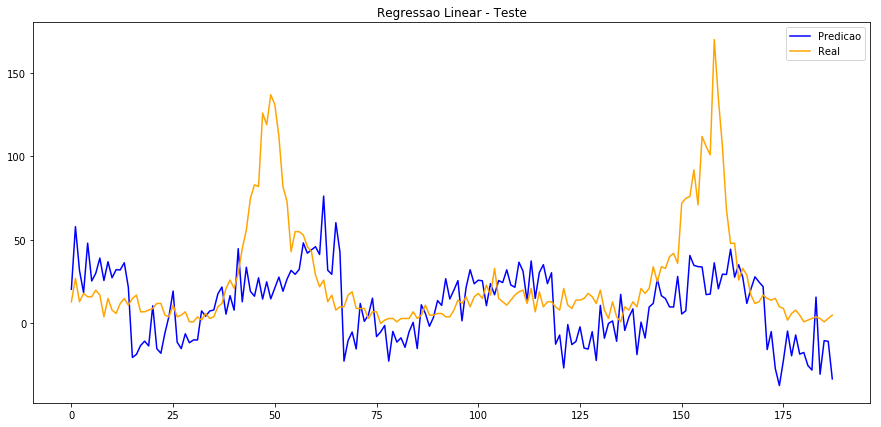

Mean absolute error: 23.349801


In [23]:
param_grid = {
    "normalize":[True,False],
    "fit_intercept":[True, False]
}

lr = LinearRegression()
lr, lr_res = find_best_params(lr, param_grid, x_train_sj, y_train_sj)

make_regression(lr, x_train_sj, x_test_sj, y_train_sj, y_test_sj, name="Regressao Linear")

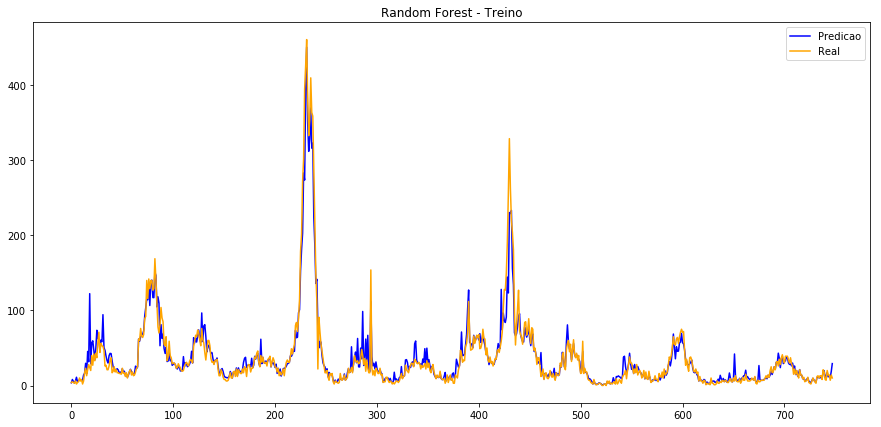

Mean absolute error: 6.918984


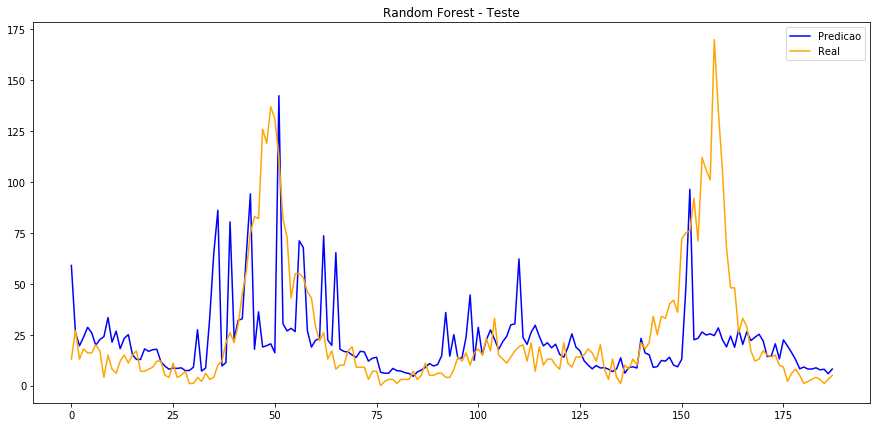

Mean absolute error: 17.507447


In [27]:
rfr = RandomForestRegressor(random_state=1)
rfr.fit(x_train_sj, y_train_sj)

make_regression(rfr, x_train_sj, x_test_sj, y_train_sj, y_test_sj, name="Random Forest")

### Treinando com o dataset todo nas duas cidades

In [16]:
x = pd.read_csv("data/dengue_features_train.csv")
y = pd.read_csv("data/dengue_labels_train.csv")
data = x.merge(y, on=("city", "year", "weekofyear")).sort_values(by=["year", "weekofyear"])
data_sj = data[data.city=="sj"]
data_sj = data_sj.drop(labels=["week_start_date","city"], axis=1)
data_iq = data[data.city=="iq"]
data_iq = data_iq.drop(labels=["week_start_date","city"], axis=1)

x_sj, _, y_sj, _, scaler_sj = preprocess_data(data_sj, columns="all", train_size=1)
x_iq, _, y_iq, _, scaler_iq = preprocess_data(data_iq, columns="all", train_size=1)

#rode para achar os melhores parametros
param_grid = {
    "max_depth":[n for n in range(1,20)],
    "max_features":[n for n in range(1,23)],
}

rf_sj, scores_sj = find_best_params(rf_sj, param_grid, x_sj, y_sj)
rf_iq, scores_iq = find_best_params(rf_iq, param_grid, x_iq, y_iq)

In [17]:
test_drivendata = pd.read_csv("data/dengue_features_test.csv")
test_drivendata_sj = test_drivendata[test_drivendata.city=="sj"]
test_drivendata_sj = test_drivendata_sj.drop(labels=["week_start_date","city"], axis=1)
x_test_sj = test_drivendata_sj.values
x_test_sj = input_missing_values(x_test_sj)
x_test_sj = scaler_sj.transform(x_test_sj)

test_drivendata_iq = test_drivendata[test_drivendata.city=="iq"]
test_drivendata_iq = test_drivendata_iq.drop(labels=["week_start_date","city"], axis=1)
x_test_iq = test_drivendata_iq.values
x_test_iq = input_missing_values(x_test_iq)
x_test_iq = scaler_iq.transform(x_test_iq)

In [18]:
y_pred_sj = rf_sj.predict(x_test_sj)
y_pred_sj = list(map(round, y_pred_sj))
y_pred_sj = list(map(int, y_pred_sj))

y_pred_iq = rf_iq.predict(x_test_iq)
y_pred_iq = list(map(round, y_pred_iq))
y_pred_iq = list(map(int, y_pred_iq))

### Salvando resultados para submissão (Random Forest Regression)

In [ ]:
results_sj = test_drivendata_sj[["year","weekofyear"]]
results_sj["city"] = "sj"
results_sj["total_cases"] = y_pred_sj

results_iq = test_drivendata_iq[["year","weekofyear"]]
results_iq["city"] = "iq"
results_iq["total_cases"] = y_pred_iq

submission = pd.concat([results_sj, results_iq])
submission[["city","year","weekofyear","total_cases"]].to_csv("submission3.csv", index=False)